<h2><b>Importing libraries</b></h2>

In [148]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import mplfinance as mpf
from pandas_datareader import data
import matplotlib.dates as mdates
import seaborn as sns
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

<h2><b>Getting data</b></h2>

In [149]:
histVale = web.DataReader('VALE', data_source='yahoo', start="2018-01-01", end="2018-12-30")
histAzul = web.DataReader('AZUL4.SA', data_source='yahoo', start="2018-01-01", end="2018-12-30")
histBB = web.DataReader('BBAS3.SA', data_source='yahoo', start="2018-01-01", end="2018-12-30")
histPetro = web.DataReader('PBR', data_source='yahoo', start="2018-01-01", end="2018-12-30")
histItau = web.DataReader('ITUB', data_source='yahoo', start="2018-01-01", end="2018-12-30")

In [150]:
historicStock = [histVale, histAzul, histBB, histPetro, histItau]

In [151]:
monthlyInflation2018 = [0.0076, 0.0007, 0.0064, 0.0057, 0.0138, 0.0187, 0.0051, 0.0070, 0.0152, 0.0089, -0.0049, -0.0108]

<h2><b>Calculating daily inflation</b></h2>

In [152]:
dayMonth30 = [4,6,9,11]
dayMonth31 = [1,3,5,7,8,10,12]
        
def calculate_daily_inflation(monthlyInflation):
    dailyInflation = []
    inflationHigh = []
    inflationLow = []
    inflationOpen = []
    inflationClose = []
    
    for index, inf in enumerate(monthlyInflation):
        if np.isin(index, dayMonth30):
            dailyInflation.append((1 + inf) ** (1/float(30)))
        elif np.isin(index, dayMonth31):
            dailyInflation.append((1 + inf) ** (1/float(31)))
        else:
            dailyInflation.append((1 + inf) ** (1/float(28)))
    
    for stock in historicStock:
        stock["Month"] = stock.index.month
        total = 1
        inflation = []
        for index, row in stock.iterrows():
            month = int(row['Month'])
            if dailyInflation[month - 1] >= 1:
                total = total * dailyInflation[month - 1]
            else:
                total = total / dailyInflation[month - 1]
            inflation.append(total)
        stock["DailyInflation"] = inflation
        
    for stock in historicStock:
        for index, row in stock.iterrows():
            inflationHigh = round(stock["High"] / stock["DailyInflation"], 2)
            inflationLow = round(stock["Low"] / stock["DailyInflation"], 2)
            inflationOpen = round(stock["Open"] / stock["DailyInflation"], 2)
            inflationClose = round(stock["Close"] / stock["DailyInflation"], 2) 
        stock["InflationHigh"] = inflationHigh
        stock["InflationLow"] = inflationLow
        stock["InflationOpen"] = inflationOpen
        stock["InflationClose"] = inflationClose

In [153]:
calculate_daily_inflation(monthlyInflation2018)

In [154]:
historicStock[0]

,High,Low,Open,Close,Volume,Adj Close,Month,DailyInflation,InflationHigh,InflationLow,InflationOpen,InflationClose
Date,,,,,,,,,,,,
2018-01-02,12.80,12.51,12.55,12.77,19189400.0,11.538283,1,1.000270,12.80,12.51,12.55,12.77
2018-01-03,12.87,12.68,12.80,12.85,20449600.0,11.610567,1,1.000541,12.86,12.67,12.79,12.84
2018-01-04,13.09,12.82,13.03,12.83,22033100.0,11.592497,1,1.000812,13.08,12.81,13.02,12.82
2018-01-05,13.09,12.73,12.80,13.09,20042800.0,11.827418,1,1.001082,13.08,12.72,12.79,13.08
2018-01-08,13.32,13.18,13.26,13.32,17507000.0,12.035233,1,1.001353,13.30,13.16,13.24,13.30
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-21,13.23,12.83,13.09,12.90,21755100.0,12.131185,12,1.073060,12.33,11.96,12.20,12.02
2018-12-24,13.03,12.59,12.82,12.60,11224100.0,11.849065,12,1.073449,12.14,11.73,11.94,11.74
2018-12-26,13.07,12.55,12.68,13.07,16587500.0,12.291053,12,1.073837,12.17,11.69,11.81,12.17


<h2><b>Calculating short and long EMAs, MACD and Signal lines</b></h2>

In [155]:
def calculate_lines():
    for stock in historicStock:
        stock["ShortEMA"] = stock["Close"].ewm(span = 12, adjust = False).mean()
        stock["LongEMA"] = stock["Close"].ewm(span = 26, adjust = False).mean()
        stock["MACD"] = stock["ShortEMA"] - stock["LongEMA"]
        stock["Signal"] = stock["MACD"].ewm(span = 9, adjust = False).mean()
        stock["InflationShortEMA"] = stock["InflationClose"].ewm(span = 12, adjust = False).mean()
        stock["InflationLongEMA"] = stock["InflationClose"].ewm(span = 26, adjust = False).mean()
        stock["InflationMACD"] = stock["InflationShortEMA"] - stock["InflationLongEMA"]
        stock["InflationSignal"] = stock["InflationMACD"].ewm(span = 9, adjust = False).mean()

In [156]:
calculate_lines()

<h2><b>Calculating Relative Strength Index (RSI)</b></h2>

In [157]:
def calculate_RSI(window):
    for stock in historicStock:
        delta = stock["Close"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        RS_up = up_days.rolling(window).mean()
        RS_down = down_days.rolling(window).mean()
        rsi= 100-100/(1+RS_up/RS_down)
        stock["RSI"] = rsi
        
        delta = stock["InflationClose"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        RS_up = up_days.rolling(window).mean()
        RS_down = down_days.rolling(window).mean()
        rsi= 100-100/(1+RS_up/RS_down)
        stock["InflationRSI"] = rsi

In [158]:
def calculate_RSI_stock(window, stock, inflation=False):
    if inflation == False:
        delta = stock["Close"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        RS_up = up_days.rolling(window).mean()
        RS_down = down_days.rolling(window).mean()
        rsi= 100-100/(1+RS_up/RS_down)
        stock["RSI"] = rsi
    else:
        delta = stock["InflationClose"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        RS_up = up_days.rolling(window).mean()
        RS_down = down_days.rolling(window).mean()
        rsi= 100-100/(1+RS_up/RS_down)
        stock["InflationRSI"] = rsi

In [159]:
calculate_RSI(14)

<h2><b>Function to plot RSI</b></h2>

In [160]:
def plot_rsi_close(stock, stockName, inflation=False):
    scaler = MinMaxScaler()
    stockScaled = pd.DataFrame(scaler.fit_transform(stock), columns=stock.columns)

    plt.figure(figsize = (20, 10))
    if inflation == False:
        ax = stockScaled["RSI"].plot()
        stockScaled["Close"].plot()
    else:
        ax = stockScaled["InflationRSI"].plot()
        stockScaled["InflationClose"].plot()
    ax.axhline(y = 0.7, color = 'red')
    ax.axhline(y = 0.3, color = 'lime')
    plt.title(f'Relação RSI e Close da {stockName}')
    plt.legend()
    plt.show()

<h2><b>Calculating Money Flow Index (MFI)</b></h2>

In [161]:
def calculate_MFI(window):
    for stock in historicStock:
        stock["TypicalPrice"] = (stock["High"] + stock["Low"] + stock["Close"]) / 3
        delta = stock["TypicalPrice"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        up_days[delta>0]=stock["TypicalPrice"]
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        down_days[delta<=0]=stock["TypicalPrice"]
        stock["1DayPositiveMoneyFlow"] = up_days * stock["Volume"]
        stock["1DayNegativeMoneyFlow"] = down_days * stock["Volume"]
        stock["nDayPositiveMoneyFlow"] = stock["1DayPositiveMoneyFlow"].rolling(window).sum()
        stock["nDayNegativeMoneyFlow"] = stock["1DayNegativeMoneyFlow"].rolling(window).sum()
        stock["MoneyFlowRatio"] = stock["nDayPositiveMoneyFlow"] / stock["nDayNegativeMoneyFlow"]
        stock["MoneyFlowIndex"] = 100 - (100 / (1 + stock["MoneyFlowRatio"]))

        stock["InflationTypicalPrice"] = (stock["InflationHigh"] + stock["InflationLow"] + stock["InflationClose"]) / 3
        delta = stock["InflationTypicalPrice"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        up_days[delta>0]=stock["InflationTypicalPrice"]
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        down_days[delta<=0]=stock["InflationTypicalPrice"]
        stock["Inflation1DayPositiveMoneyFlow"] = up_days * stock["Volume"]
        stock["Inflation1DayNegativeMoneyFlow"] = down_days * stock["Volume"]
        stock["InflationnDayPositiveMoneyFlow"] = stock["Inflation1DayPositiveMoneyFlow"].rolling(window).sum()
        stock["InflationnDayNegativeMoneyFlow"] = stock["Inflation1DayNegativeMoneyFlow"].rolling(window).sum()
        stock["InflationMoneyFlowRatio"] = stock["InflationnDayPositiveMoneyFlow"] / stock["InflationnDayNegativeMoneyFlow"]
        stock["InflationMoneyFlowIndex"] = 100 - (100 / (1 + stock["InflationMoneyFlowRatio"]))

In [162]:
calculate_MFI(14)

<h2><b>Function to plot MFI</b></h2>

In [163]:
def plot_mfi(stock, stockName, inflation=False):

    plt.figure(figsize = (20, 10))
    if inflation == False:
        ax = stock["MoneyFlowIndex"].plot()
    else:
        ax = stock["InflationMoneyFlowIndex"].plot()
    ax.axhline(y = 20, color = 'red')
    ax.axhline(y = 80, color = 'lime')
    plt.title(f'MFI da {stockName}')
    plt.legend()
    plt.show()

<h2><b>Calculating Stochastic Oscillator</b></h2>

In [164]:
def calculate_stochastic_oscillator(window):
    for stock in historicStock:
        nHigh = stock["High"].rolling(window).max()
        nLow = stock["Low"].rolling(window).min()
        stock["StochasticOscillator"] = ((stock["Close"] - nLow) / (nHigh - nLow)) * 100
        
        nHigh = stock["InflationHigh"].rolling(window).max()
        nLow = stock["InflationLow"].rolling(window).min()
        stock["InflationStochasticOscillator"] = ((stock["InflationClose"] - nLow) / (nHigh - nLow)) * 100

In [165]:
calculate_stochastic_oscillator(14)

<h2><b>Function to plot Stochastic Oscillator</b></h2>

In [166]:
def plot_stochastic_oscillator(stock, stockName, inflation=False):

    plt.figure(figsize = (20, 10))
    if inflation == False:
        ax = stock["StochasticOscillator"].plot()
    else:
        ax = stock["InflationStochasticOscillator"].plot()
    ax.axhline(y = 20, color = 'red')
    ax.axhline(y = 80, color = 'lime')
    plt.title(f'Oscilador estocástico da {stockName}')
    plt.legend()
    plt.show()

<h2><b>Function to plot correlation matrix</b></h2>

In [167]:
def show_corr_matrix(stock, inflation=False):

    if inflation == False:
        corrMatrix = stock[["Close", "RSI", "MoneyFlowIndex", "StochasticOscillator", "ShortEMA", "LongEMA", "MACD"]].corr()
    else:
        corrMatrix = stock[["InflationClose", "InflationRSI", "InflationMoneyFlowIndex", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]].corr()

    sns.heatmap(corrMatrix, annot=True)
    plt.figure(figsize = (100,100))
    plt.show()

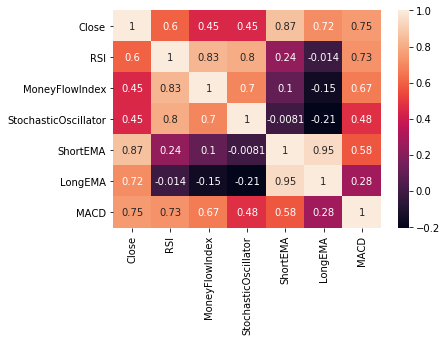

<Figure size 7200x7200 with 0 Axes>

In [168]:
show_corr_matrix(historicStock[0])

<h2><b>Function to predict traditional SVM</b></h2>

In [169]:
svmRegressorClose = svm.SVR(kernel="linear")
svmRegressorHigh = svm.SVR(kernel="linear")
svmRegressorLow = svm.SVR(kernel="linear")
svmRegressorNu = svm.NuSVR(kernel="linear")

In [170]:
def predict_svm_traditional(stock, inflation=False, feature='close'):
    if feature == 'close':
        if inflation == False:
            stockX = stock[["RSI", "MoneyFlowIndex", "StochasticOscillator", "ShortEMA", "MACD", "Low", "High"]][15:]
            stockY = stock["Close"][15:]
        else:
            stockX = stock[["InflationRSI", "InflationMoneyFlowIndex", "InflationStochasticOscillator", "InflationShortEMA", "InflationMACD"]][15:]
            stockY = stock["InflationClose"][15:]
        X = np.array(stockX)
        y = np.array(stockY)
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

        svmRegressorClose.fit(X_train, y_train)

        print(X_test)

        y_pred = svmRegressorClose.predict(X_test)
        print('Predicted values: ', y_pred)
        print('Testing values: ', y_test)
        print('Coefficients: \n', svmRegressorClose.coef_)

        return y_pred, y_test, y_train
    elif feature == 'high':
        if inflation == False:
            stockX = stock[["RSI", "ShortEMA", "MACD"]][15:]
            stockY = stock["High"][15:]
        else:
            stockX = stock[["InflationRSI", "InflationMoneyFlowIndex", "InflationStochasticOscillator", "InflationShortEMA", "InflationMACD"]][15:]
            stockY = stock["InflationHigh"][15:]
        X = np.array(stockX)
        y = np.array(stockY)
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

        svmRegressorHigh.fit(X_train, y_train)

        print(X_test)

        y_pred = svmRegressorHigh.predict(X_test)
        print('Predicted values: ', y_pred)
        print('Testing values: ', y_test)
        print('Coefficients: \n', svmRegressorHigh.coef_)

        return y_pred, y_test, y_train
    elif feature == 'low':
        if inflation == False:
            stockX = stock[["RSI","ShortEMA", "MACD"]][15:]
            stockY = stock["Low"][15:]
        else:
            stockX = stock[["InflationRSI", "InflationMoneyFlowIndex", "InflationStochasticOscillator", "InflationShortEMA", "InflationMACD"]][15:]
            stockY = stock["InflationLow"][15:]
        X = np.array(stockX)
        y = np.array(stockY)
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

        svmRegressorLow.fit(X_train, y_train)

        print(X_test)

        y_pred = svmRegressorLow.predict(X_test)
        print('Predicted values: ', y_pred)
        print('Testing values: ', y_test)
        print('Coefficients: \n', svmRegressorLow.coef_)

        return y_pred, y_test, y_train
        

In [171]:
def predict_plot_svm(stock, inflation=False, feature='close'):
    y_pred, y_test, y_train = predict_svm_traditional(stock, inflation, feature)
    
    print('R^2 value: ', r2_score(y_test, y_pred))
    print('MAE score: ', mean_absolute_error(y_test, y_pred))
    print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
    
    plt.plot(y_test, label="Real value")
    plt.plot(y_pred, label="Prediction")
    plt.legend()
    plt.show()

In [209]:
def predict_svm_traditional_forward(stock, inflation=False):
    y_test = []
    y_pred = []
    provStock = stock[["RSI", "MoneyFlowIndex", "StochasticOscillator", "ShortEMA", "LongEMA", "MACD", "High", "Low", "Close"]][:26]
    if inflation == False:
        stockX = provStock[["RSI", "MoneyFlowIndex", "StochasticOscillator", "ShortEMA", "MACD", "High", "Low"]]
        stockY = provStock["Close"]
    else:
        stockX = provStock[["InflationRSI", "InflationMoneyFlowIndex", "InflationStochasticOscillator", "InflationShortEMA", "InflationMACD", "InflationHigh", "InflationLow"]]
        stockY = provStock["InflationClose"]
    X = np.array(stockX)
    y = np.array(stockY)
    
    y_test.append(y[len(y) - 1])
    y[len(y) - 1] = svmRegressorClose.predict((X[len(y) - 1]).reshape(1, -1))
#     yHigh = svmRegressorHigh.predict()
    y_pred.append(y[len(y) - 1])
    
    shortEma = y[-12:].mean()
    longEma = y[-26:].mean()
    macd = shortEma - longEma
    
    provStock = provStock.append({"RSI": 0, "MoneyFlowIndex": 0, "StochasticOscillator": 0, "ShortEMA": shortEma, "LongEMA": longEma, "MACD": macd, "High": 0, "Low": 0, "Close": y[len(y) - 1]}, ignore_index=True)
    calculate_RSI_stock(14, provStock)
    print(provStock)


#     svmRegressor.fit(X_train, y_train)
    
#     print(X_test)
    
#     y_pred = svmRegressor.predict(X_test)
#     print('Predicted values: ', y_pred)
#     print('Testing values: ', y_test)
#     print('Coefficients: \n', svmRegressor.coef_)
    
#     return y_pred, y_test, y_train

[[ 7.17647104e+01  7.26001285e+01  6.42361431e+01  1.48476845e+01
   5.39577572e-01  1.49799995e+01  1.55200005e+01]
 [ 6.95035506e+01  6.64724160e+01  5.65891714e+01  1.48726562e+01
   5.12557126e-01  1.48100004e+01  1.50799999e+01]
 [ 6.75879369e+01  6.75747559e+01  5.57692510e+01  1.49245552e+01
   5.01500554e-01  1.49099998e+01  1.53599997e+01]
 [ 6.69230747e+01  6.76868191e+01  6.79348122e+01  1.50192390e+01
   5.13447673e-01  1.51400003e+01  1.56400003e+01]
 [ 5.38461538e+01  6.13526062e+01  1.46666938e+01  1.49932023e+01
   4.61913994e-01  1.48500004e+01  1.55299997e+01]
 [ 4.85714201e+01  5.44349663e+01  1.86206702e+01  1.49865558e+01
   4.24251789e-01  1.48400002e+01  1.52900000e+01]
 [ 5.60411370e+01  5.96009800e+01  4.00000263e+01  1.50286241e+01
   4.14638964e-01  1.50500002e+01  1.54899998e+01]
 [ 5.28925639e+01  5.93223588e+01  5.31468933e+01  1.50949897e+01
   4.18336719e-01  1.51599998e+01  1.56899996e+01]
 [ 5.72271406e+01  6.77133372e+01  5.45454606e+01  1.51542220e+0

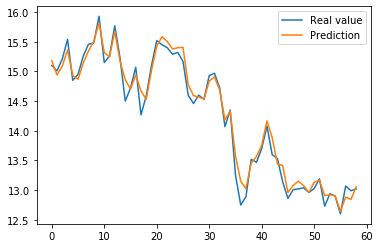

[[ 7.17647104e+01  1.48476845e+01  5.39577572e-01]
 [ 6.95035506e+01  1.48726562e+01  5.12557126e-01]
 [ 6.75879369e+01  1.49245552e+01  5.01500554e-01]
 [ 6.69230747e+01  1.50192390e+01  5.13447673e-01]
 [ 5.38461538e+01  1.49932023e+01  4.61913994e-01]
 [ 4.85714201e+01  1.49865558e+01  4.24251789e-01]
 [ 5.60411370e+01  1.50286241e+01  4.14638964e-01]
 [ 5.28925639e+01  1.50949897e+01  4.18336719e-01]
 [ 5.72271406e+01  1.51542220e+01  4.18061852e-01]
 [ 6.47696553e+01  1.52735725e+01  4.48979759e-01]
 [ 5.34675561e+01  1.52545613e+01  4.05864336e-01]
 [ 5.26195954e+01  1.52553980e+01  3.76234189e-01]
 [ 5.17401457e+01  1.53345676e+01  3.89415895e-01]
 [ 4.76495704e+01  1.53184802e+01  3.52228660e-01]
 [ 4.40711441e+01  1.51925602e+01  2.60845777e-01]
 [ 4.72061669e+01  1.51198587e+01  2.03826779e-01]
 [ 4.86891356e+01  1.51121881e+01  1.84751145e-01]
 [ 3.90705730e+01  1.49826207e+01  1.03882819e-01]
 [ 4.76102922e+01  1.49222176e+01  6.48676346e-02]
 [ 5.12820559e+01  1.49495688e+

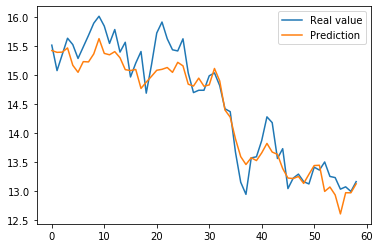

[[ 7.17647104e+01  1.48476845e+01  5.39577572e-01]
 [ 6.95035506e+01  1.48726562e+01  5.12557126e-01]
 [ 6.75879369e+01  1.49245552e+01  5.01500554e-01]
 [ 6.69230747e+01  1.50192390e+01  5.13447673e-01]
 [ 5.38461538e+01  1.49932023e+01  4.61913994e-01]
 [ 4.85714201e+01  1.49865558e+01  4.24251789e-01]
 [ 5.60411370e+01  1.50286241e+01  4.14638964e-01]
 [ 5.28925639e+01  1.50949897e+01  4.18336719e-01]
 [ 5.72271406e+01  1.51542220e+01  4.18061852e-01]
 [ 6.47696553e+01  1.52735725e+01  4.48979759e-01]
 [ 5.34675561e+01  1.52545613e+01  4.05864336e-01]
 [ 5.26195954e+01  1.52553980e+01  3.76234189e-01]
 [ 5.17401457e+01  1.53345676e+01  3.89415895e-01]
 [ 4.76495704e+01  1.53184802e+01  3.52228660e-01]
 [ 4.40711441e+01  1.51925602e+01  2.60845777e-01]
 [ 4.72061669e+01  1.51198587e+01  2.03826779e-01]
 [ 4.86891356e+01  1.51121881e+01  1.84751145e-01]
 [ 3.90705730e+01  1.49826207e+01  1.03882819e-01]
 [ 4.76102922e+01  1.49222176e+01  6.48676346e-02]
 [ 5.12820559e+01  1.49495688e+

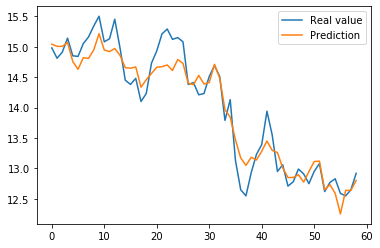

In [198]:
predict_plot_svm(historicStock[0])
predict_plot_svm(historicStock[0], feature='high')
predict_plot_svm(historicStock[0], feature='low')

In [210]:
predict_svm_traditional_forward(historicStock[0])

KeyError: 'InflationClose'

<h2><b>Function to predict Nu SVM</b></h2>

In [175]:
def predict_svm_nu(stock, inflation=False):
    if inflation == False:
        stockX = stock[["RSI", "MoneyFlowIndex", "StochasticOscillator", "ShortEMA", "MACD"]][15:]
        stockY = stock["Close"][15:]
    else:
        stockX = stock[["InflationRSI", "InflationMoneyFlowIndex", "InflationStochasticOscillator", "InflationShortEMA", "InflationMACD"]][15:]
        stockY = stock["InflationClose"][15:]
    X = np.array(stockX)
    y = np.array(stockY)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

    svmRegressorNu.fit(X_train, y_train)
    
    y_pred = svmRegressorNu.predict(X_test)
    print('Predicted values: ', y_pred)
    print('Testing values: ', y_test)
    print('Coefficients: \n', svmRegressorNu.coef_)
    
    return y_pred, y_test, y_train

In [176]:
def predict_plot_svm_nu(stock, inflation=False):
    y_pred, y_test, y_train = predict_svm_nu(stock, inflation)
    
    print('R^2 value: ', r2_score(y_test, y_pred))
    print('MAE score: ', mean_absolute_error(y_test, y_pred))
    print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
    
    plt.plot(y_test, label="Real value")
    plt.plot(y_pred, label="Prediction")
    plt.legend()
    plt.show()

<h2><b>Scaling data for LSTM</b></h2>

In [177]:
scaler = MinMaxScaler()
stockScaled = []
stocksScaled = []

for stock in historicStock:
    stocksScaled.append(stock)
    
for stock in stocksScaled:
    stockScaled.append(pd.DataFrame(scaler.fit_transform(stock), columns=historicStock[0].columns))

In [178]:
def predict_LSTM(stock, inflation=False):
    if inflation == False:
        stockX = stock[["RSI", "MoneyFlowIndex", "StochasticOscillator", "ShortEMA", "MACD"]][15:]
        stockY = stock["Close"][15:]
    else:
        stockX = stock[["InflationRSI", "InflationMoneyFlowIndex", "InflationStochasticOscillator", "InflationShortEMA", "InflationMACD"]][15:]
        stockY = stock["InflationClose"][15:]
    X = np.array(stockX)
    y = np.array(stockY)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

In [179]:
predict_LSTM(stockScaled[0])